In [254]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_random_state

from tslearn.clustering import KernelKMeans

import matplotlib.pyplot as plt
rs = check_random_state(42)

In [256]:
seed = 42
n_samples = 500

X, y = make_circles(n_samples=n_samples, factor=0.2, noise=0.05, random_state=seed)
len(np.where(np.array(y) == 1)[0])

# Find indices of samples with label 1
indices_label_1 = np.where(np.array(y) == 0)[0]

# Define the number of samples to remove
num_samples_to_remove = 200

# Randomly select indices to remove
indices_to_remove = np.random.choice(indices_label_1, size=num_samples_to_remove, replace=False)

# Remove selected samples
X = np.delete(X, indices_to_remove, axis=0)
y = np.delete(y, indices_to_remove)

# Number of samples after removal
print("Number of samples after removal:", len(X))
#X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)

Number of samples after removal: 300


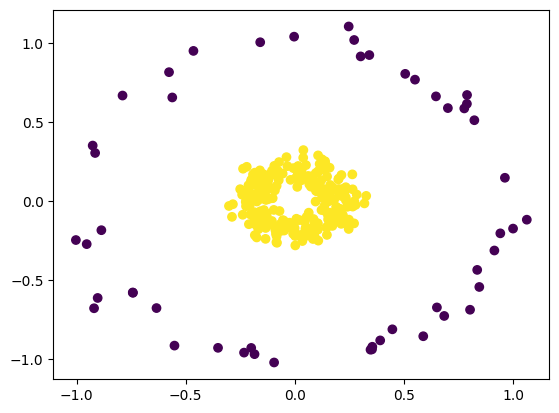

In [257]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### We want a function that given the kernel and number of clusters to return me the initial partition using the kernel k-means++ algorithm

In [258]:
def calculate_kernel_distances_between_points(center_index, centers_indices, X, kernel_matrix, kernel_distances_between_points):
    for i in range(X.shape[0]):
        if i not in centers_indices: 
            kernel_distances_between_points[center_index, i] = kernel_matrix[center_index, center_index] - 2 * kernel_matrix[center_index, i] + kernel_matrix[i, i]
    return kernel_distances_between_points

def get_initial_center_index(X):
    return random.randint(0, X.shape[0] - 1)

def select_next_center_index(centers_indices, probability_array):
    while(True):
        selected_index = np.random.choice(len(probability_array), p=probability_array)
        if(selected_index not in centers_indices):
            return selected_index

def calculate_points_probabilities_to_be_selected(kernel_distances_between_points):
    return kernel_distances_between_points / np.sum(kernel_distances_between_points)

def calculate_minimum_distances_from_centers_and_partition(centers_indices, kernel_distances_between_points):
    minimum_distances = np.zeros(kernel_distances_between_points.shape[1])
    partition = np.zeros(kernel_distances_between_points.shape[1], dtype=int)

    for i, column in enumerate(kernel_distances_between_points.T):
        nonzero_indices = np.nonzero(column)[0]
        if len(nonzero_indices) > 0:
            partition[i] = nonzero_indices[np.argmin(column[nonzero_indices])]
            minimum_distances[i] = column[partition[i]]
    
    # Make 0 the distances for centers and set their partition to their index
    minimum_distances[centers_indices] = 0
    partition[centers_indices] = centers_indices
    
    return minimum_distances, partition

def scale_partition(partition):
    return LabelEncoder().fit_transform(partition)

def calculate_initial_partition_with_kkmeans_pp(K, X, kernel_matrix):
    centers_indices = []
    n_samples = X.shape[0]
    kernel_distances_between_points = np.zeros((n_samples, n_samples))
    
    for i in range(K):
        if i != 0:
            centers_indices.append(select_next_center_index(centers_indices, probabilities))
        else:
            centers_indices.append(get_initial_center_index(X))
        
        kernel_distances_between_points = calculate_kernel_distances_between_points(centers_indices[i], centers_indices, X, kernel_matrix, kernel_distances_between_points)
        minimum_distances, partition = calculate_minimum_distances_from_centers_and_partition(centers_indices, kernel_distances_between_points)
        probabilities = calculate_points_probabilities_to_be_selected(minimum_distances)
        
    return centers_indices, partition

def calculate_initial_partition(K, X, kernel_matrix, method):
    if method == 'KKmeans++':
        print("Executing KKMeans++ Initialization")
        centers_indices, partition = calculate_initial_partition_with_kkmeans_pp(K, X, kernel_matrix)
    elif method == 'Froggy':
        print("Executing Froggy Initialization")
        partition = rs.randint(K, size=X.shape[0])
        centers_indices = np.unique(partition)
    elif method == 'case3':
        print("Executing code for case3")
    else:
       print("Error!")
    return centers_indices, partition    
       

In [259]:
def find_cluster_indices(array, value):
    return np.where(np.array(array) == value)[0]

def custom_kernel_kmeans(X, centers_indices, initial_partition, kernel_matrix, max_iter=300, tol=1e-4):
    n_samples = X.shape[0]
    n_clusters = len(centers_indices)
    distances = np.zeros((n_clusters,n_samples))
    
    for iter in range(max_iter):
        
        for i in range(n_clusters):
            cluster_indices = find_cluster_indices(initial_partition, centers_indices[i])
            n_cluster_samples =  len(cluster_indices)
            stable_sum = (np.sum(kernel_matrix[k, l] for k in cluster_indices for l in cluster_indices)) / pow(n_cluster_samples, 2)
            
            for j in range(n_samples):
                sample_sum = np.sum(kernel_matrix[j,index] for index in cluster_indices) / n_cluster_samples
                distances[i,j] = kernel_matrix[j,j] - (2 * sample_sum) + stable_sum 
        
        min_distances = np.min(distances, axis=0)
        total_error = np.sum(min_distances)
        print(f"\n Total Error is: {total_error}!")
        
        next_partition = np.argmin(distances, axis=0)
        are_equal = np.array_equal(initial_partition, next_partition)
        if(are_equal):
            print(f"\n Finished in {iter} iterations!")
            return np.unique(next_partition), next_partition
        else:
            initial_partition = next_partition
            centers_indices = np.unique(next_partition)

# 6 are good
def kernel_kmeans_pp(X, K, kernel_matrix, n_init=6, method = 'KKmeanspp'):
    for _ in range(n_init):
        centers_indices, partition = calculate_initial_partition(K, X, kernel_matrix, method)
        centers_indices, partition = custom_kernel_kmeans(X, centers_indices, initial_partition = partition, kernel_matrix=kernel_matrix, max_iter=300, tol=1e-4)
        plt.scatter(X[:, 0], X[:, 1], c = partition)
        plt.show()

In [260]:
K = 2 
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=5)

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


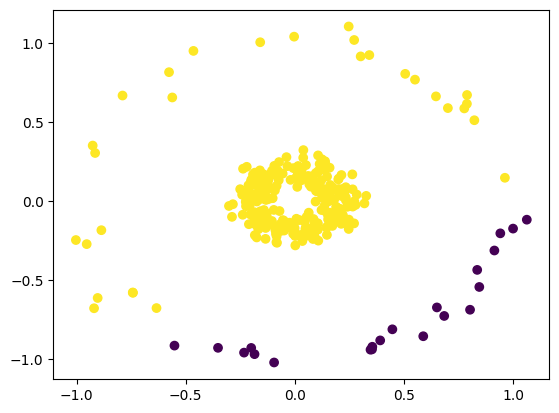

In [261]:
kmeans = KMeans(n_clusters=2).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 300 1-dimensional timeseries
  warnings.warn(


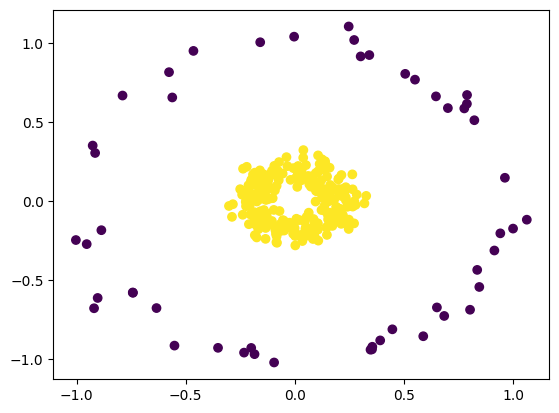

In [262]:
# Should find a way to init the fucking centers!
kernel_kmeans = KernelKMeans(n_clusters=2, n_init=1, kernel='precomputed').fit(kernel_matrix)
plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_)
plt.show()

Executing KKMeans++ Initialization

 Total Error is: 137.12498882870244!

 Total Error is: 123.01202425376943!

 Finished in 1 iterations!


C:\Users\APDHP-DM\AppData\Local\Temp\ipykernel_22740\2509054733.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  stable_sum = (np.sum(kernel_matrix[k, l] for k in cluster_indices for l in cluster_indices)) / pow(n_cluster_samples, 2)
C:\Users\APDHP-DM\AppData\Local\Temp\ipykernel_22740\2509054733.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sample_sum = np.sum(kernel_matrix[j,index] for index in cluster_indices) / n_cluster_samples


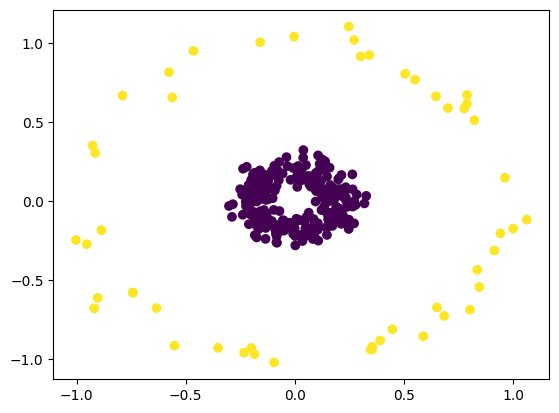

In [263]:
kernel_kmeans_pp(X, 2, kernel_matrix, n_init=1, method='KKmeans++')